# Getting emperical/sample error estimates from LIGO parameter estimates in both O3a and O3b

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_context("notebook")
sns.set_palette("colorblind")
import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

In [2]:
O3a_samples = glob('O3a-samples/*comoving.h5')
O3b_samples = glob('O3b-samples/*mixed_cosmo.h5')

print(len(O3a_samples))
print(len(O3b_samples))

39
36


## Let's start with just O3a:

Text(0, 0.5, '$m_1\\ [M_\\odot]$')

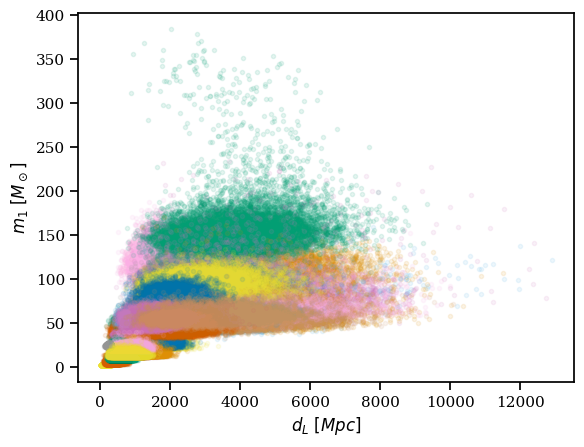

In [3]:
cols = ['mass_1', 'luminosity_distance']
for f in O3a_samples:
    with h5py.File(f, 'r') as hf:
        posterior = np.array(hf['PublicationSamples/posterior_samples'])
        plt.scatter(posterior['luminosity_distance'], posterior['mass_1'], alpha=0.1, marker='.')
plt.xlabel(r"$d_L\ [Mpc]$")
plt.ylabel(r"$m_1\ [M_\odot]$")

Well that's a bit unexpected. It seems that the luminosity distance is actually much more poorly constrained than $m_1$ for most of these events...

Text(0, 0.5, '$m_1\\ [M_\\odot]$')

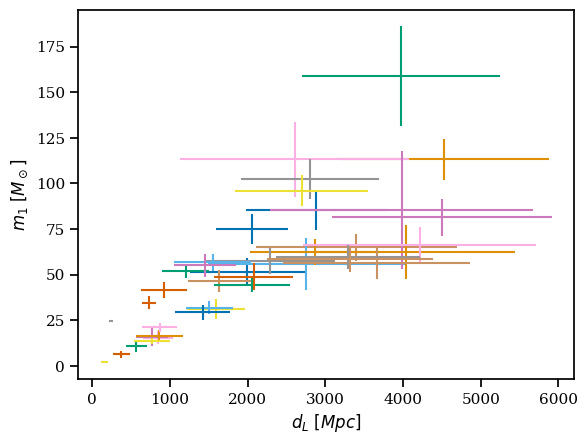

In [4]:
for f in O3a_samples:
    with h5py.File(f, 'r') as hf:
        posterior = np.array(hf['PublicationSamples/posterior_samples'])
        m_err = np.std(posterior['mass_1'])
        m_mean = np.mean(posterior['mass_1'])

        dL_err = np.std(posterior['luminosity_distance'])
        dL_mean = np.mean(posterior['luminosity_distance'])
        plt.errorbar(dL_mean, m_mean, xerr=dL_err, yerr=m_err)
plt.xlabel(r"$d_L\ [Mpc]$")
plt.ylabel(r"$m_1\ [M_\odot]$")

<ErrorbarContainer object of 3 artists>

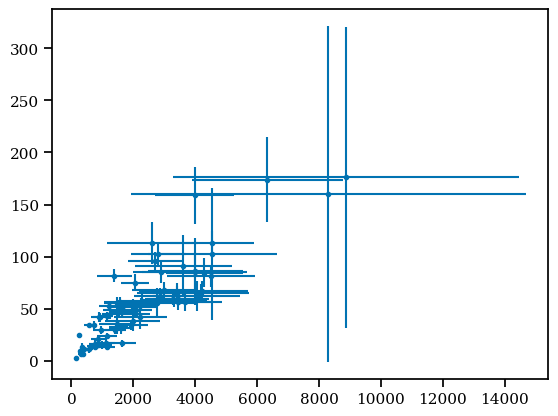

In [5]:
m_errs = []
dL_errs = []
m_means = []
dL_means = []

for f in O3a_samples:
    with h5py.File(f, 'r') as hf:
        posterior = np.array(hf['PublicationSamples/posterior_samples'])
        m_errs.append(np.std(posterior['mass_1']))
        m_means.append(np.mean(posterior['mass_1']))

        dL_errs.append(np.std(posterior['luminosity_distance']))
        dL_means.append(np.mean(posterior['luminosity_distance']))

for f in O3b_samples:
    with h5py.File(f, 'r') as hf:
        posterior = np.array(hf['C01:Mixed/posterior_samples'])
        m_errs.append(np.std(posterior['mass_1']))
        m_means.append(np.mean(posterior['mass_1']))

        dL_errs.append(np.std(posterior['luminosity_distance']))
        dL_means.append(np.mean(posterior['luminosity_distance']))
plt.errorbar(dL_means, m_means, xerr=dL_errs, yerr=m_errs, fmt='.')

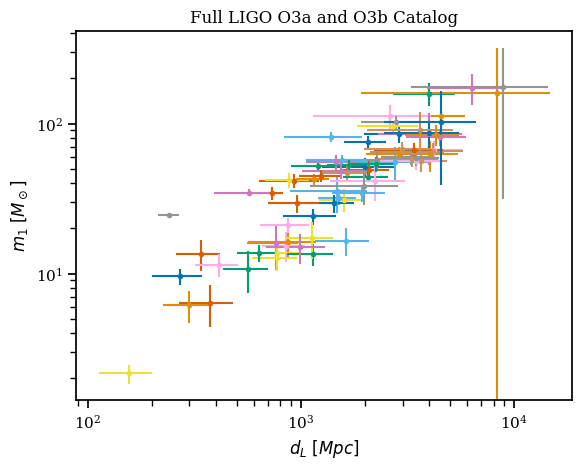

In [13]:
### Plot for thesis

for i in range(len(dL_errs)):
    plt.errorbar(dL_means[i], m_means[i], xerr=dL_errs[i], yerr=m_errs[i], fmt='.')
plt.title("Full LIGO O3a and O3b Catalog")
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.xscale('log')
plt.yscale('log')

[]

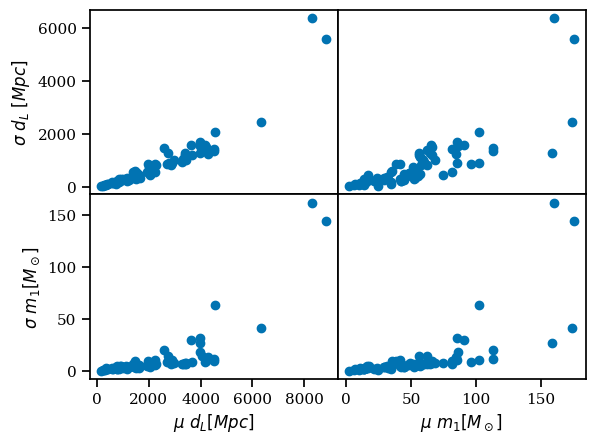

In [6]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0, wspace=0)


axs[0,0].scatter(dL_means, dL_errs)
axs[0,0].set_ylabel(r"$\sigma\ d_L\ [Mpc]$")


axs[0,1].scatter(m_means, dL_errs)
axs[0,1].set_yticks([])

axs[1,0].scatter(dL_means, m_errs)
axs[1,0].set_xlabel(r"$\mu\ d_L [Mpc]$")
axs[1,0].set_ylabel(r"$\sigma\ m_1 [M_\odot]$")


axs[1,1].scatter(m_means, m_errs)
axs[1,1].set_xlabel(r"$\mu\ m_1 [M_\odot]$")
axs[1,1].set_yticks([])

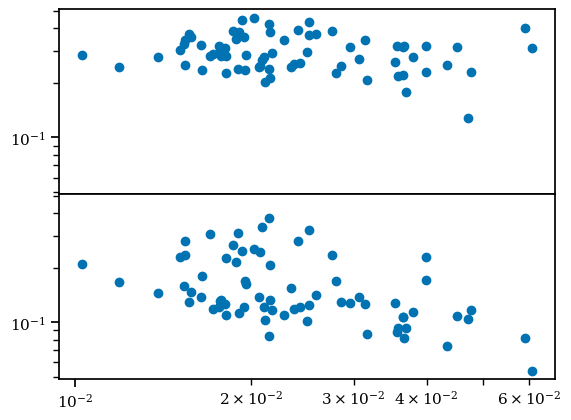

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

m_mu = np.array(m_means)
m_sigma = np.array(m_errs)
dl_mu = np.array(dL_means)
dl_sigma = np.array(dL_errs)

m_dl = m_mu/dl_mu
sigma_dl = dl_sigma/dl_mu
sigma_m  = m_sigma/m_mu

sigma_dl_cut = sigma_dl[(sigma_dl<0.5) & (sigma_m<0.5) & (m_dl < 0.1)]
sigma_m_cut = sigma_m[(sigma_dl<0.5) & (sigma_m<0.5) & (m_dl < 0.1)]
m_dl_cut = m_dl[(sigma_dl<0.5) & (sigma_m<0.5) & (m_dl < 0.1)]

axs[0].scatter(m_dl_cut, sigma_dl_cut)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].scatter(m_dl_cut, sigma_m_cut)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

In [26]:
A_dl = np.vstack([m_dl_cut, np.ones(len(m_dl_cut))]).T
m_dl, c_dl = np.linalg.lstsq(A_dl, sigma_dl_cut, rcond=None)[0]
print(m_dl, c_dl)

A_m = np.vstack([m_dl_cut, np.ones(len(m_dl_cut))]).T
m_m, c_m = np.linalg.lstsq(A_dl, sigma_m_cut, rcond=None)[0]
print(m_m, c_m)

-0.9308735356009178 0.32116864835559333
-2.848294888849169 0.2335009794466498


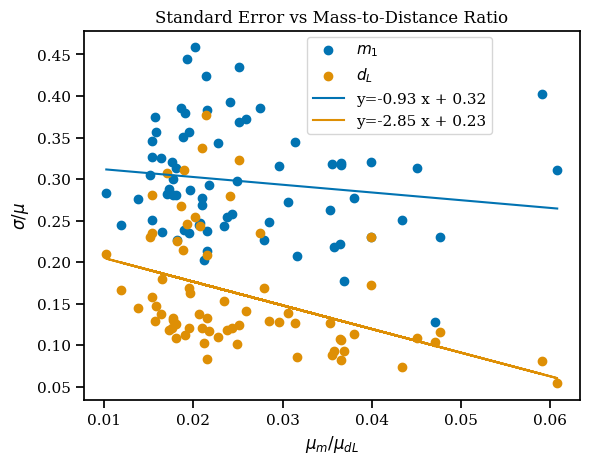

In [27]:
plt.scatter(m_dl_cut, sigma_dl_cut, label=r"$m_1$")
plt.scatter(m_dl_cut, sigma_m_cut,  label=r"$d_L$")
plt.plot(np.sort(m_dl_cut), m_dl*np.sort(m_dl_cut)+c_dl, label=f"y=%2.2f x + %2.2f"%(m_dl, c_dl))
plt.plot(m_dl_cut, m_m*m_dl_cut+c_m, label=f"y=%2.2f x + %2.2f"%(m_m, c_m))
plt.title("Standard Error vs Mass-to-Distance Ratio")
plt.xlabel(r"$\mu_m/\mu_{dL}$")
plt.ylabel(r"$\sigma/\mu$")
plt.legend(loc=(0.45, 0.72))


## Let's try logspace instead...

In [46]:
logm_dl = np.log(m_dl_cut)
log_sigma_dl = np.log(sigma_dl_cut)
log_sigma_m = np.log(sigma_m_cut)

coeffs_dl = np.polyfit(logm_dl,log_sigma_dl,deg=1)
print(coeffs_dl)
poly_dl = np.poly1d(coeffs_dl)

coeffs_m = np.polyfit(logm_dl,log_sigma_m,deg=1)
print(coeffs_m)
poly_m = np.poly1d(coeffs_m)

yfit_log_dl = lambda x: np.exp(poly_dl(np.log(x)))
yfit_log_m = lambda x: np.exp(poly_m(np.log(x)))

[-0.11385276 -1.66453492]
[-0.55045078 -3.97546921]


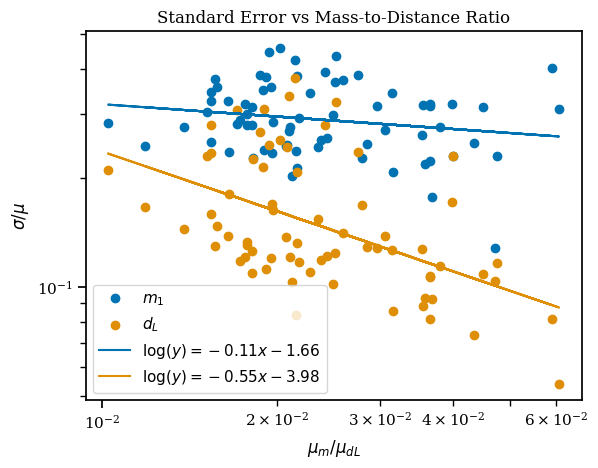

In [53]:
plt.scatter(m_dl_cut, sigma_dl_cut, label=r"$m_1$")
plt.scatter(m_dl_cut, sigma_m_cut,  label=r"$d_L$")
plt.plot(m_dl_cut, yfit_log_dl(m_dl_cut), label=r"$\log(y)=%.2fx%.2f$"%(coeffs_dl[0], coeffs_dl[1]))
plt.plot(m_dl_cut, yfit_log_m(m_dl_cut), label=r"$\log(y)=%.2fx%.2f$"%(coeffs_m[0], coeffs_m[1]))
plt.title("Standard Error vs Mass-to-Distance Ratio")
plt.xlabel(r"$\mu_m/\mu_{dL}$")
plt.ylabel(r"$\sigma/\mu$")
plt.legend()
plt.xscale('log')
plt.yscale('log')